# Testing playground for fine-tuning 

Run the following cell for importing libraries and the Oxford-IIIT Pet dataset. Replace `pretrained_weights_path` with the path with a valid pretrained encoder weight file (.pth).

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torchvision.transforms as T
import torchvision

import time

from vit import ViT
from finetune import FineTune
from utils import OxfordIIITPetsAugmented, ToDevice, get_device

import matplotlib.pyplot as plt

# Path to the pre-trained weights
pretrained_weights_path = 'pretrained_encoder.pth'

# Set device
device = get_device()
print(f'Using device: {device}, {torch.cuda.get_device_name()}')

# Define some transformations for the Oxford IIIT Pet dataset
def tensor_trimap(t):
	x = t * 255
	x = x.to(torch.long)
	x = x - 1
	return x

def args_to_dict(**kwargs):
	return kwargs

transform_dict = args_to_dict(
	pre_transform=T.ToTensor(),
	pre_target_transform=T.ToTensor(),
	common_transform=T.Compose([
		ToDevice(get_device()),
		T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
		# Random Horizontal Flip as data augmentation.
		T.RandomHorizontalFlip(p=0.5),
	]),
	post_transform=T.Compose([
		# Color Jitter as data augmentation.
		T.ColorJitter(contrast=0.3),
	]),
	post_target_transform=T.Compose([
		T.Lambda(tensor_trimap),
	]),
)

# Download Oxford-IIIT Pet Dataset - train and test sets
trainset = OxfordIIITPetsAugmented(
	root='data',
	split="trainval",
	target_types="segmentation",
	download=True,
	**transform_dict,
)
testset = OxfordIIITPetsAugmented(
	root='data',
	split="test",
	target_types="segmentation",
	download=True,
	**transform_dict,
)

trainloader = torch.utils.data.DataLoader(
		trainset,
		batch_size=1024,
		shuffle=True,
)
		
		
testloader = torch.utils.data.DataLoader(
	testset,
	batch_size=128,
	shuffle=True,
)

# Instantiate encoder (ViT to be fine-tuned)
encoder = ViT(
    image_size = 128,
    patch_size = 32,
    num_classes = 10,
    dim = 128,
    depth = 12,
    heads = 8,
    mlp_dim = 384
).to(device)

# Print number of parameters
print('Number of parameters (encoder):', sum(p.numel() for p in encoder.parameters()))

# instantiate fine-tuning model, load weights from pre-trained model
model = FineTune(
    encoder = encoder,
    weights_path = pretrained_weights_path,
).to(device)

# Print number of parameters
print('Number of parameters (segmentation head):', 
		sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in encoder.parameters()))


Using device: cuda, NVIDIA GeForce GTX TITAN X
Number of parameters (encoder): 4742794
patch_size: 32
Number of parameters (segmentation head): 396288


 This one is for playing around with the fine-tuned model, after loading fine-tuned model weights. You first need to train the segmentation head by running main_finetune.py.

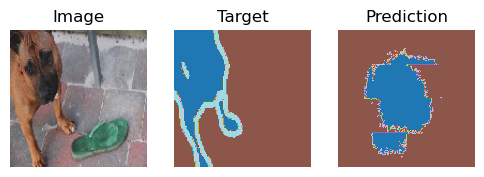

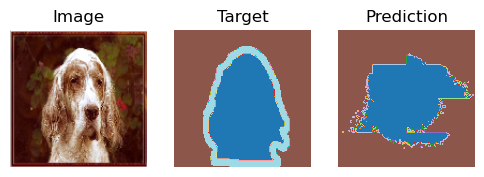

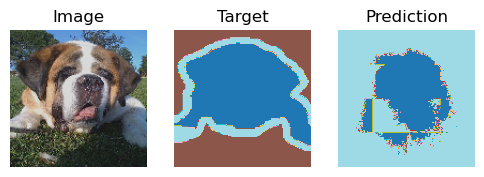

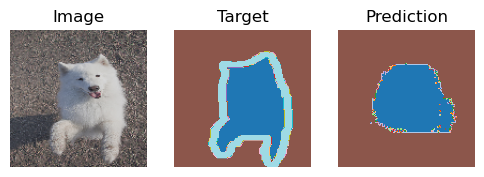

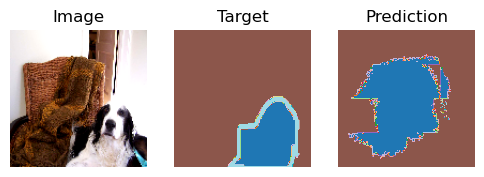

Epoch 3 | Batch 24
Epoch 3 - Loss: 0.11382226645946503
Epoch 4 | Batch 0
Epoch 4 | Batch 1
Epoch 4 | Batch 2
Epoch 4 | Batch 3
Epoch 4 | Batch 4
Epoch 4 | Batch 5
Epoch 4 | Batch 6
Epoch 4 | Batch 7
Epoch 4 | Batch 8
Epoch 4 | Batch 9
Epoch 4 | Batch 10
Epoch 4 | Batch 11
Epoch 4 | Batch 12
Epoch 4 | Batch 13
Epoch 4 | Batch 14
Epoch 4 | Batch 15
Epoch 4 | Batch 16
Epoch 4 | Batch 17
Epoch 4 | Batch 18
Epoch 4 | Batch 19
Epoch 4 | Batch 20
Epoch 4 | Batch 21
Epoch 4 | Batch 22
Epoch 4 | Batch 23
Epoch 4 | Batch 24
Epoch 4 - Loss: 0.10945104897022247
Epoch 5 | Batch 0
Epoch 5 | Batch 1
Epoch 5 | Batch 2
Epoch 5 | Batch 3
Epoch 5 | Batch 4
Epoch 5 | Batch 5
Epoch 5 | Batch 6
Epoch 5 | Batch 7


In [ ]:
#load weights from fine-tuned model
model.load_state_dict(torch.load('finetuned_weights.pth'))

# Prediction mode
model.eval()

def display_example():
	#pick image in test set
	idx = torch.randint(0, len(testset), (1,)).item()
	img, target = testset[idx]
	img = img.unsqueeze(0)
	target = target.unsqueeze(0)

	with torch.no_grad():
		_, pred_patches, target_patches = model(img, target)

	pred_patches = pred_patches[0]
	target_patches = target_patches[0]

	#make empty tensor to store full image
	pred_full = torch.zeros(1, 128, 128)
	target_full = torch.zeros(1, 128, 128)

	patch_i = 0
	for row in range(4):
		for col in range(4):
			target_plot = target_patches[:,patch_i].cpu().numpy().reshape(3, 32, 32).transpose(1, 2, 0)
			pred_plot = pred_patches[:,patch_i].cpu().numpy().reshape(3, 32, 32).transpose(1, 2, 0)
			#take argmax to plot
			target_plot = target_plot.argmax(axis=2)
			pred_plot = pred_plot.argmax(axis=2)

			#add to full image
			target_full[0, row*32:(row+1)*32, col*32:(col+1)*32] = torch.tensor(target_plot)
			pred_full[0, row*32:(row+1)*32, col*32:(col+1)*32] = torch.tensor(pred_plot)
			patch_i += 1

			
	#plot targetand prediction
	fig, axs = plt.subplots(1, 3, figsize=(6, 2))
	axs[0].imshow(img[0].cpu().numpy().transpose(1, 2, 0))
	axs[0].set_title('Image')
	axs[1].imshow(target_full[0].cpu().numpy(), cmap='tab20')
	axs[1].set_title('Target')
	axs[2].imshow(pred_full[0].cpu().numpy(), cmap='tab20')
	axs[2].set_title('Prediction')
	for ax in axs:
		ax.axis('off')
	plt.show()

# Display example
for _ in range(5):
	display_example()

